# Depresión en México

## Instalación de Librerías

In [1]:
pip install geopandas

In [2]:
pip install nltk

In [3]:
pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


## Importación de Librerías

In [4]:
import pandas as pd
import geopandas as gpd
import nltk
import numpy as np

from scipy.stats import trim_mean, skew, kurtosis
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [5]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Tema

Antes de comenzar, establecemos el tema <code>darkgrid</code>, el cual se aplicara a todas las graficas hechas con la libreria <code>Seaborn</code>.


In [9]:
sns.set(style="darkgrid")

## Funciones



### Estimados de Locación y Variabilidad

La función <code>estimados</code> nos permite obtener la media, mediana, media truncada, desviacion estandar, minimo, maximo, rango, cuantiles y rango intercuartilico de una o más columnas de un conjunto de datos.

Este proceso se realiza mediante las funciones <code>mean</code>, <code>median</code>, <code>std</code>, <code>min</code>, <code>max</code>, <code>quantile</code> y <code>loc</code> de la librería <code>Pandas</code> y, <code>trim_mean</code> de la librería <code>SciPy</code>.

In [10]:
def estimados(datos, columnas, recorte=0.025):
  datos_estimados = pd.DataFrame(columns=["mean", "median", "trim_mean", "std", "min", "max", "range", "quantile_25", "quantile_75", "iqr"])
  for columna in columnas:
    promedio = datos[columna].mean()
    mediana = datos[columna].median()
    media_truncada = trim_mean(a=datos[columna], proportiontocut=recorte)
    desviacion_estandar = datos[columna].std()
    minimo = datos[columna].min()
    maximo = datos[columna].max()
    rango = maximo - minimo
    percentil_25 = datos[columna].quantile(q=0.25)
    percentil_75 = datos[columna].quantile(q=0.75)
    iqr = percentil_75 - percentil_25
    datos_estimados.loc[columna] = list([promedio, mediana, media_truncada, desviacion_estandar, minimo, maximo, rango, percentil_25, percentil_75, iqr])
  return datos_estimados

### Rango Intercuartilico

La función <code>filtro</code> nos permite extender un poco el rango de valores en los que se encuentra mayor concentracion de datos de una columna a traves del rango intercuartilico y los cuantiles, descartando también aquellos valores que no se encuentren dentro de ese rango.

Este proceso se realiza mediante la función <code>loc</code> de la librería <code>Pandas</code>.

In [11]:
def filtro(datos, estimados, columna):
  iqr = estimados["iqr"].loc[columna]
  return datos[(datos[columna] > estimados["quantile_25"].loc[columna] - iqr * 1.5) & (datos[columna] < estimados["quantile_75"].loc[columna] + iqr * 1.5)]

### Generador de Columnas Categoricas

La función <code>categoricas</code> genera un nuevo <code>DataFrame</code> con una columna categorica y otra numerica basada en un conjunto de columnas.

Este proceso se realiza mediante las funciones <code>groupby</code>, <code>last</code>, <code>reset_index</code>, <code>rename</code>, <code>append</code> de la libreria <code>Pandas</code>.

In [12]:
def categoricas(datos, columnas_agrupar, columnas_convertir, nombre_columnas=["value", "category"]):
  nuevos_datos = pd.DataFrame(columns=columnas_agrupar + ["value", "category"])
  for columna in columnas_convertir:
    grupo = datos.groupby(by=columnas_agrupar)[columna].last().reset_index().rename(columns={columna: "value"})
    grupo["category"] = columna
    nuevos_datos = nuevos_datos.append(grupo)
  return nuevos_datos.rename(columns={"value": nombre_columnas[0], "category": nombre_columnas[1]})

### Regresión Lineal Simple

La función <code>regresion_lineal</code> calcula un modelo de regresión lineal simple.

Este proceso se realiza mediante las funciones <code>LinearRegression</code>, <code>fit</code>, <code>predict</code> y <code>score</code> de la libreria <code>sklearn</code>, <code>date</code> de la libreria <code>datetime</code> y, <code>scatterplot</code> y <code>lineplot</code> de la libreria <code>Seaborn</code>.

In [13]:
def regresion_lineal(datos, independiente, dependiente, titulo, etiqueta_x, etiqueta_y):
  model = LinearRegression()
  model.fit(datos[independiente].to_frame(), datos[dependiente])
  y_predict = model.predict(datos[independiente].to_frame())
  prediccion = ""
  for periodo in range(date.today().year + 1, date.today().year + 6):
    prediccion += "| {}: {:.0f} ".format(periodo, model.predict((pd.Series([periodo])).to_frame())[0])
  sns.scatterplot(data=datos, x=independiente, y=dependiente).set(title=f"{titulo}\n({round(model.score(datos[independiente].to_frame(), datos[dependiente]), 4) * 100}% Eficacia)\n{prediccion}  |\n", xlabel=etiqueta_x, ylabel=etiqueta_y);
  sns.lineplot(data=datos, x=independiente, y=y_predict, color="#FF7F0E");
  

## Lectura de Datos

Comenzamos cargando el conjunto de datos sobre la __depresión__ que se encuentra almacenado en el repositorio de GitHub.

Este proceso se realiza mediante las funciones <code>read_csv</code>, <code>reset_index</code> y <code>rename</code> de la librería <code>Pandas</code>.

In [14]:
depresion = pd.read_csv("https://raw.githubusercontent.com/MauricioCarmona/DepresionMexico/main/data/depression.csv", index_col=0).reset_index().rename(columns={"entity": "country", "sub-region": "sub_region"})

Despues cargamos el conjunto de datos correspondiente a los __codigos ISO de 3 letras__ que se encuentra almacenado en el repositorio de GitHub.

Este proceso se realiza mediante las funciones <code>read_csv</code> y <code>rename</code> de la librería <code>Pandas</code>.

In [15]:
codigos_iso = pd.read_csv("https://raw.githubusercontent.com/MauricioCarmona/DepresionMexico/main/data/iso_codes.csv").rename(columns={"Entity": "country", "Code": "code"})

Por ultimo cargamos el conjunto de datos correspondiente a las __coordenadas geograficas__ que se encuentra almacenado en el repositorio de GitHub.

Este proceso se realiza mediante las funciones <code>read_file</code> de la librería <code>GeoPandas</code> y <code>rename</code> de la librería <code>Pandas</code>.

In [16]:
coordenadas_geograficas = gpd.read_file(filename="https://raw.githubusercontent.com/MauricioCarmona/DepresionMexico/main/data/countries.geojson").rename(columns={"ADMIN": "country", "ISO_A3": "code"})

## Preparación

Una vez cargados los datos, crearemos un solo <code>DataFrame</code> que contenga la información relevante de los tres conjuntos mediante la unión de las columnas  <code>country</code> y <code>code</code>.

Este proceso se realiza mediante la función <code>merge</code>, <code>drop</code> y <code>rename</code> de la librería <code>Pandas</code>.

In [17]:
datos_globales = depresion.merge(right=codigos_iso, on="country").merge(right=coordenadas_geograficas, on="code").drop(columns=["country_y"]).rename(columns={"country_x": "country"})

Ahora crearemos un nuevo <code>DataFrame</code> basado en la información de <code>datos_globales</code> que unicamente contenga información sobre <code>México</code>.



In [18]:
datos_de_mexico = datos_globales[datos_globales["country"] == "Mexico"]

## Exploración

Una parte fundamental previa al analisis, es conocer una pequeña muestra de la información que contiene nuestro conjunto de datos.

Este proceso se realiza mediante la función <code>head</code> de la librería <code>Pandas</code>.

In [19]:
datos_globales.head()

,country,year,schizophrenia,bipolar_disorder,eating_disorder,anxiety,drug_addiction,depression,alcoholism,from_20_to_24,from_10_to_14,all,above_69,from_30_to_34,from_15_to_19,from_25_to_29,from_50_to_69,standardized,from_15_to_49,prevalence_in_males,prevalence_in_females,population,suicide_rate,depression_rate,depression_prevalence,region,sub_region,code,geometry
0,Afghanistan,1990,0.160560,0.697779,0.101855,4.828830,1.677082,4.071831,0.672404,4.417802,1.594676,3.218871,5.202803,5.799034,3.455708,5.175856,5.917752,4.071831,4.939766,3.499982,4.647815,12412000.0,10.318504,4039.755763,318435.813670,Asia,Southern Asia,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903..."
1,Afghanistan,1991,0.160312,0.697961,0.099313,4.829740,1.684746,4.079531,0.671768,4.433524,1.588356,3.203468,5.192849,5.814828,3.451880,5.176729,5.927093,4.079531,4.902682,3.503947,4.655772,13299000.0,10.327010,4046.256034,329044.773956,Asia,Southern Asia,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903..."
2,Afghanistan,1992,0.160135,0.698107,0.096692,4.831108,1.694334,4.088358,0.670644,4.453689,1.577980,3.156559,5.176872,5.829745,3.434982,5.160249,5.945656,4.088358,4.837097,3.508912,4.662066,14486000.0,10.271411,4053.709902,382544.572895,Asia,Southern Asia,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903..."
3,Afghanistan,1993,0.160037,0.698257,0.094336,4.830864,1.705320,4.096190,0.669738,4.464517,1.577201,3.120655,5.167355,5.853060,3.420210,5.148767,5.966915,4.096190,4.813657,3.513429,4.669012,15817000.0,10.376123,4060.203474,440381.507393,Asia,Southern Asia,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903..."
4,Afghanistan,1994,0.160022,0.698469,0.092439,4.829423,1.716069,4.099582,0.669260,4.462960,1.570846,3.082179,5.157549,5.852851,3.425222,5.148227,5.975907,4.099582,4.839340,3.515578,4.673050,17076000.0,10.575915,4062.290365,456916.645489,Asia,Southern Asia,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903..."


Como podemos observar, contamos con información desde el año __1990__ hasta el año __2017__ sobre el impacto de algunos de los trastornos mentales relacionados con la __depresión__ segun la __edad__ y el __sexo__ en todos los paises del mundo.

## Analisis Estadistico

Debido a que una pequeña muestra no nos brinda mucha informacion sobre las columnas de nuestro conjunto de datos, podemos visualizar datos estadisticos que nos permitan conocer de forma general la distribucion de los datos.

Este proceso se realiza mediante la función <code>estimados</code>.

In [20]:
estimados_de_datos_globales = estimados(datos=datos_globales, columnas=["schizophrenia", "bipolar_disorder", "eating_disorder", "anxiety", "drug_addiction", "depression", "alcoholism", "from_10_to_14", "from_15_to_19", "from_20_to_24", "from_25_to_29", "from_30_to_34","from_15_to_49", "from_50_to_69", "above_69", "depression_prevalence", "prevalence_in_females", "prevalence_in_males", "suicide_rate", "depression_rate"])
round(number=estimados_de_datos_globales, ndigits=3)

,mean,median,trim_mean,std,min,max,range,quantile_25,quantile_75,iqr
schizophrenia,0.208,0.198,0.206,0.042,0.147,3.750000e-01,2.280000e-01,0.179,0.230,0.051
bipolar_disorder,0.718,0.695,0.716,0.164,0.315,1.207000e+00,8.920000e-01,0.616,0.831,0.215
eating_disorder,0.234,0.180,0.226,0.155,0.074,9.440000e-01,8.700000e-01,0.122,0.280,0.158
anxiety,3.948,3.506,3.897,1.138,2.023,8.967000e+00,6.944000e+00,3.176,4.662,1.486
drug_addiction,0.833,0.707,0.800,0.442,0.384,3.452000e+00,3.069000e+00,0.523,0.906,0.382
depression,3.474,3.460,3.450,0.673,2.140,6.603000e+00,4.463000e+00,2.954,3.880,0.927
alcoholism,1.563,1.470,1.499,0.864,0.447,5.475000e+00,5.028000e+00,0.959,1.857,0.898
from_10_to_14,1.371,1.261,1.352,0.396,0.710,3.303000e+00,2.593000e+00,1.071,1.580,0.509
from_15_to_19,3.054,2.889,3.005,0.849,1.498,9.053000e+00,7.555000e+00,2.523,3.384,0.861
from_20_to_24,3.746,3.476,3.685,1.077,1.719,1.127600e+01,9.557000e+00,3.045,4.200,1.154


Observamos que la __ansiedad__ y la __depression__ son los __trastornos mentales__ que mas predominan en todo el mundo y van aumentando conforme a la <code>edad</code>.

Tambien hemos encontrado una pequeña dispersión en la __ansiedad__, la __depression__ y el __indice de suicidio__ (el valor __maximo__ se encuentra distante del valor __promedio__ tomando en cuenta la __desviacion estandar__), lo que significa que el impacto de estos dos __trastornos mentales__ es mayor en uno o mas paises.

Es por esto que usaremos <code>datos_globales</code> para agrupar los paises por region.

Este proceso se realiza mediante las funciones <code>groupby</code>, <code>mean</code> y <code>reset_index</code> de la librería <code>Pandas</code>.

In [21]:
datos_globales_agrupados = datos_globales.groupby(by=["region", "country"]).mean().reset_index()

Ahora, usaremos <code>datos_globales_agrupados</code> para explorar la dispersión de la __ansiedad__.

Este proceso se realiza mediante la función <code>boxplot</code> de la librería <code>Seaborn</code>.

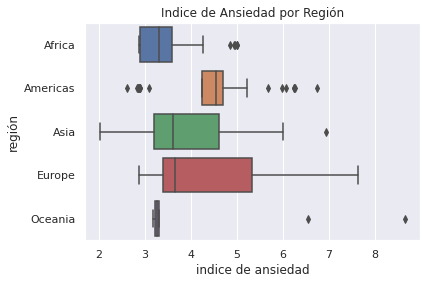

In [22]:
sns.boxplot(data=datos_globales_agrupados, x="anxiety", y="region").set(title="Indice de Ansiedad por Región", xlabel="indice de ansiedad", ylabel="región");

Observamos que la dispersion en la __ansiedad__ no es tan drastica, no obstante, hay un pais de __Oceania__ que se encuentra con un indice de ansiedad mayor a 8%, por lo que podemos intentar descartarlo.

Este proceso se realiza mediante la función <code>filtro</code>.

In [23]:
datos_globales_agrupados_filtrados = filtro(datos=datos_globales_agrupados, estimados=estimados_de_datos_globales, columna="anxiety")

Una vez que aplicamos la función <code>filtro</code> a <code>datos_globales_agrupados</code>, comprobamos si aun existe dispersion.

Este proceso se realiza mediante la función <code>boxplot</code> de la librería <code>Seaborn</code>.

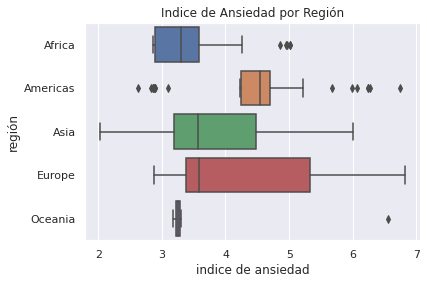

In [24]:
sns.boxplot(data=datos_globales_agrupados_filtrados, x="anxiety", y="region").set(title="Indice de Ansiedad por Región", xlabel="indice de ansiedad", ylabel="región");

Observamos que solamente se descartaron algunos paises, por lo que decidimos conservar los cambios.

Ahora, usaremos <code>datos_globales_agrupados_filtrados</code> para explorar la dispersión en el __indice de depresion__.

Este proceso se realiza mediante la función <code>boxplot</code> de la librería <code>Seaborn</code>.

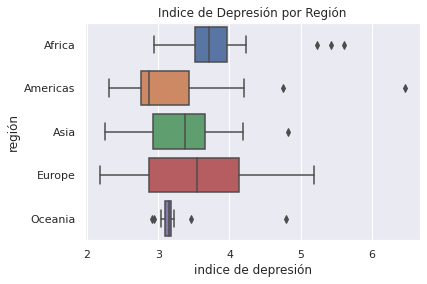

In [25]:
sns.boxplot(data=datos_globales_agrupados_filtrados, x="depression", y="region").set(title="Indice de Depresión por Región", xlabel="indice de depresión", ylabel="región");

Observamos que la dispersion del __indice de depresion__ se debe a que unos cuantos paises de __America__ y __Africa__ se encuentran con un __indice de depresión__ mayor a 6, por lo que podemos intentar descartarlos.

Este proceso se realiza mediante la función <code>filtro</code>.

In [26]:
datos_globales_agrupados_filtrados = filtro(datos=datos_globales_agrupados_filtrados, estimados=estimados_de_datos_globales, columna="depression")

Una vez que aplicamos la función <code>filtro</code> a <code>datos_globales_agrupados_filtrados</code>, comprobamos si aun existe dispersion.

Este proceso se realiza mediante la función <code>boxplot</code> de la librería <code>Seaborn</code>.

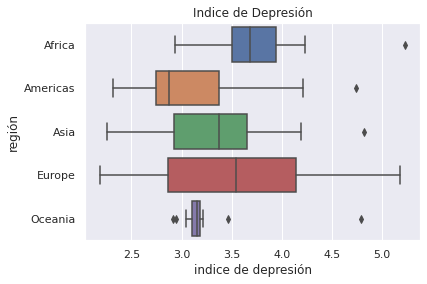

In [27]:
sns.boxplot(data=datos_globales_agrupados_filtrados, x="depression", y="region").set(title="Indice de Depresión", xlabel="indice de depresión", ylabel="región");

Observamos que la dispersion es menor, por lo que es conveniente conservar los cambios.

Ahora, usaremos nuevamente <code>datos_globales_agrupados_filtrados</code> para explorar la dispersión del __indice de suicidio__.

Este proceso se realiza mediante la función <code>boxplot</code> de la librería <code>Seaborn</code>.

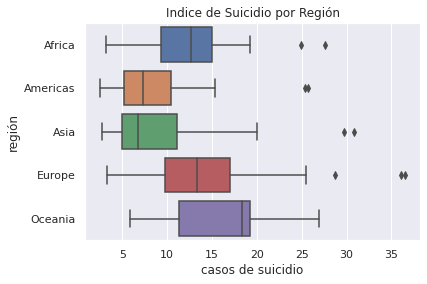

In [28]:
sns.boxplot(data=datos_globales_agrupados_filtrados, x="suicide_rate", y="region").set(title="Indice de Suicidio por Región", xlabel="casos de suicidio", ylabel="región");

Observamos que la dispersion en la __tasa de suicidio__ se debe a que algunos paises superan los 30 casos de suicidio por cada 100,000 personas, por lo que podemos intentar descartarlos.

Este proceso se realiza mediante la función <code>filtro</code>.

In [29]:
datos_globales_agrupados_filtrados = filtro(datos=datos_globales_agrupados_filtrados, estimados=estimados_de_datos_globales, columna="suicide_rate")

Una vez que aplicamos la función <code>filtro</code> a <code>datos_globales_agrupados_filtrados</code>, comprobamos si aun existe dispersion.

Este proceso se realiza mediante la función <code>boxplot</code> de la librería <code>Seaborn</code>.

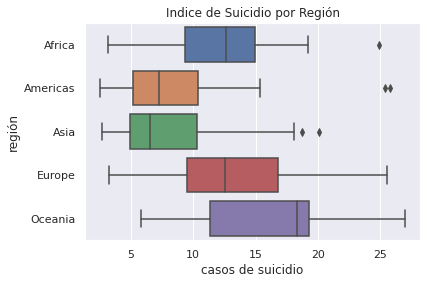

In [30]:
sns.boxplot(data=datos_globales_agrupados_filtrados, x="suicide_rate", y="region").set(title="Indice de Suicidio por Región", xlabel="casos de suicidio", ylabel="región");

Como podemos observar, la dispersion se ha reducido en gran medida, por lo que es conveniente conservar los cambios.

Si deseamos conocer los paises que fueron descartados, podemos usar <code>datos_globales</code> y <code>datos_globales_agrupados_filtrados</code> para crear una lista comprimida.

Este proceso se realiza mediante la función <code>unique</code> de la librería <code>Pandas</code>.

In [31]:
paises_descartados = [pais for pais in pd.unique(datos_globales["country"]) if pais not in pd.unique(datos_globales_agrupados_filtrados["country"])]
paises_descartados

['Belarus',
 'Greenland',
 'Iran',
 'Kazakhstan',
 'Lesotho',
 'Lithuania',
 'Morocco',
 'New Zealand',
 'Norway',
 'Russia',
 'Sri Lanka',
 'Zimbabwe']

Observamos que 12 paises fueron descartados y uno de ellos es __Groelandia__, cuyo indice de depresión e indice de suicidio es el mas alto a nivel mundial.

Ahora que hemos descartado los paises que generaban dispersion en nuestros datos, es necesario conocer la forma en que se distribuyen nuestros datos para encontrar las regiones con mayor densidad.

### AQUI VA GRAFICA DE DENSIDAD CON ASIMETRIA Y CURTOSIS

In [32]:
lista_de_trastornos = ["schizophrenia", "bipolar_disorder", "eating_disorder", "anxiety", "drug_addiction", "depression", "alcoholism"]

Ahora vamos a crear un nuevo <code>DataFrame</code> que no contenga los paises previamente descartados.

Este proceso se realiza mediante la función <code>isin</code> de la libreria <code>Pandas</code>.

In [33]:
datos_globales_filtrados = datos_globales[~datos_globales["country"].isin(paises_descartados)]

Comenzaremos visualizando el impacto que tienen los __trastornos mentales__ en cada region del mundo, asi podemos indagar acerca de cuales provocan altas tasas de suicidio.

Este proceso se realiza mediante las funciones <code>groupby</code>, <code>mean</code> y <code>reset_index</code> de libreria <code>Pandas</code> y, <code>catplot</code> de la libreria <code>Seaborn</code>.

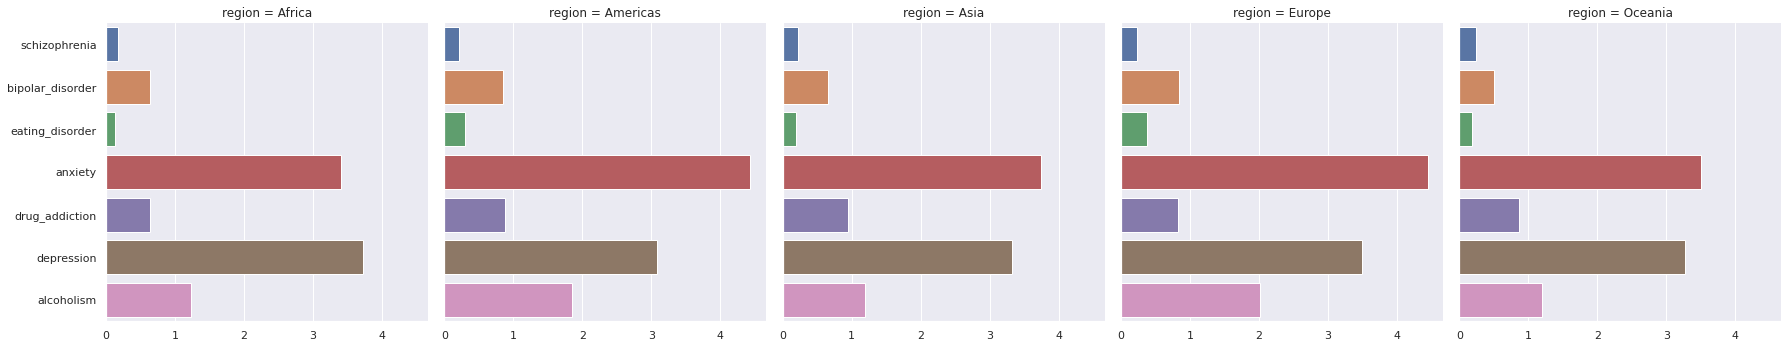

In [34]:
trastornos_por_region = datos_globales_filtrados.groupby("region")[lista_de_trastornos].mean().reset_index()
sns.catplot(data=trastornos_por_region, col="region", orient='h', kind="bar");

Observamos que la __ansiedad__ se encuentra por encima de el __indice de depresion__ en todas las regiones del mundo a excepcion de __Africa__, esto podria deberse a uno de los paises que se encontraba fuera del rango y que no fuimos capaces de descartar.

Esto no supone un problema, ya que nuestro analisis esta centrado en __México__. Asi que ahora, conoceremos la evolucion de los trastornos en cada region del mundo. Para esto, es necesario crear una variable categorica de los __trastornos mentales__.

Este proceso se realiza mediante la funcion <code>categoricas</code>.

In [35]:
trastornos_mentales_por_pais = categoricas(
    datos=datos_globales_filtrados, 
    columnas_agrupar=["region", "country", "year"], 
    columnas_convertir=lista_de_trastornos,
    nombre_columnas=["rate", "disorder"])

Una vez creado el <code>DataFrame</code> con la variable categorica, graficamos las lineas de tiempo de cada trastorno mental por region.

Este proceso se realiza mediante la funcion <code>relplot</code> de la libreria <code>Seaborn</code>.

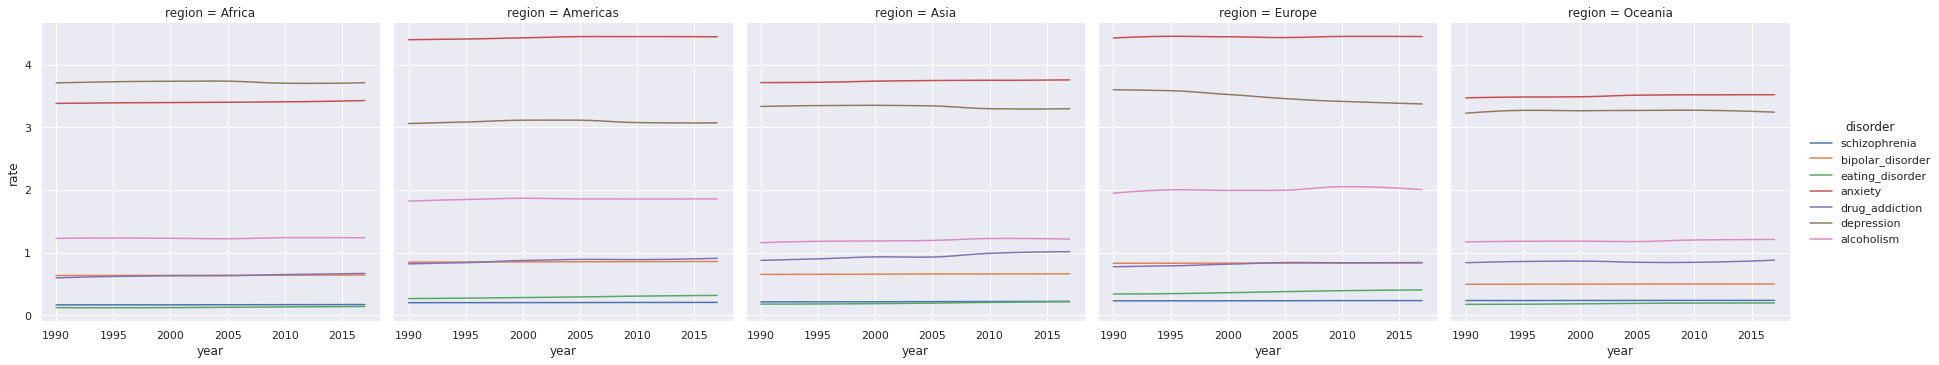

In [36]:
sns.relplot(data=trastornos_mentales_por_pais, x="year", y="rate", hue="disorder", col="region", kind="line", ci=None);

Observamos que la __ansiedad__ y la __depresion__ se han mantenido casi constantes desde 1990 hasta 2017 en todas las regiones, asi que podemos estimar que seguira afectando en gran medida a personas de todos los paises.

### Evolución de los Trastornos Mentales en México

Hemos descubierto que en los paises de __America__ predomina la __ansiedad__ y la __depresion__. Dado que el analisis fue a nivel mundial, esto quiza no representa la situacion de __Mexico__, asi que es nuestro deber comprobar que ha sido y que será de nuestro pais.



Primero creamos un <code>DataFrame</code> con la variable categorica correspondiente a los trastornos mentales.

Este proceso se realiza mediante la función <code>categoricas</code>.

In [37]:
trastornos_mentales_en_mexico = categoricas(
    datos=datos_de_mexico, 
    columnas_agrupar=["country", "year"], 
    columnas_convertir=lista_de_trastornos,
    nombre_columnas=["rate", "disorder"])

Una vez creado el <code>DataFrame</code> con la variable categorica, graficamos una linea de tiempo de los __trastornos mentales__.

Este proceso se realiza mediante la funcion <code>relplot</code> de la libreria <code>Seaborn</code>.

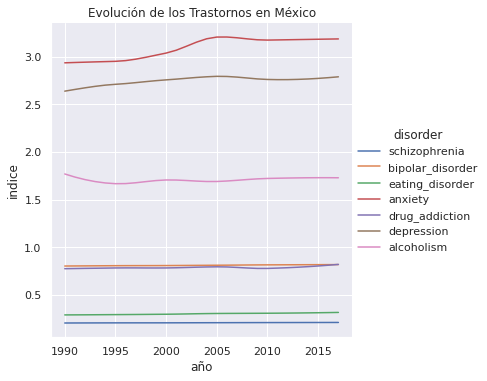

In [38]:
sns.relplot(data=trastornos_mentales_en_mexico, x="year", y="rate", hue="disorder", kind="line").set(title="Evolución de los Trastornos en México", xlabel="año", ylabel="indice");

Como podemos observar, la linea de tiempo de __México__ es muy similar a la linea de tiempo de __America__, lo que quiere decir que la situación en los paises de __America__ es compartida.

Ahora, es tiempo de conocer el impacto de los trastornos segun el __sexo__, ya que la _Organización Mundial de la Salud_ mencionaba que las __mujeres__ se ven mas afectadas que los __hombres__.

Para esto, creamos un nuevo <code>DataFrame</code> que contenga una columna categorica correspondiente al __sexo__.

Este proceso se realiza mediante la función <code>categoricas</code>.

In [39]:
trastornos_mentales_en_mexico_segun_el_sexo = categoricas(
    datos=datos_de_mexico, 
    columnas_agrupar=["country", "year"], 
    columnas_convertir=["prevalence_in_females", "prevalence_in_males"],
    nombre_columnas=["rate", "gender"])

Una vez creado el <code>DataFrame</code> con la variable categorica, graficamos una linea de tiempo de los __trastornos mentales__ segun el __sexo__.

Este proceso se realiza mediante la funcion <code>relplot</code> de la libreria <code>Seaborn</code>.

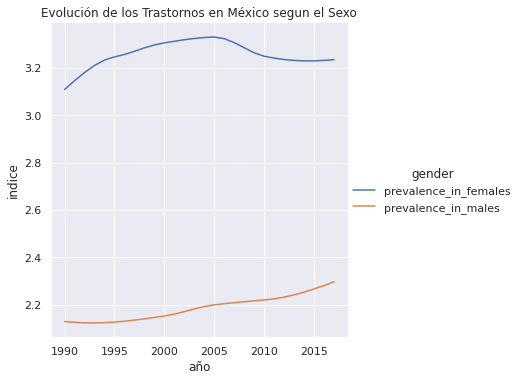

In [40]:
sns.relplot(data=trastornos_mentales_en_mexico_segun_el_sexo, x="year", y="rate", hue="gender", kind="line").set(title="Evolución de los Trastornos en México segun el Sexo", xlabel="año", ylabel="indice");

Como podemos observar, la __prevalencia en mujeres__ es 1.5 veces mayor que la __prevalencia en hombres__ y asi comprobamos que lo que planteo la _Organización Mundial de la Salud_ es verdad.

Ahora es momento de identificar los grupos vulnerables, es decir, el impacto de los __trastornos mentales__ segun la __edad__.

Para esto, creamos un <code>DataFrame</code> que contenga una columna 
categorica correspondiente a la __edad__.

Este proceso se realiza mediante la función <code>categoricas</code>.

In [41]:
trastornos_mentales_en_mexico_segun_la_edad = categoricas(
    datos=datos_de_mexico, 
    columnas_agrupar=["country", "year"], 
    columnas_convertir=["from_10_to_14", "from_15_to_19", "from_20_to_24", "from_25_to_29", "from_30_to_34", "from_15_to_49", "from_50_to_69", "above_69"],
    nombre_columnas=["rate", "age"])

Una vez creado el <code>DataFrame</code> con la variable categorica, graficamos una linea de tiempo de los __trastornos mentales__ segun la __edad__.

Este proceso se realiza mediante la funcion <code>relplot</code> de la libreria <code>Seaborn</code>.

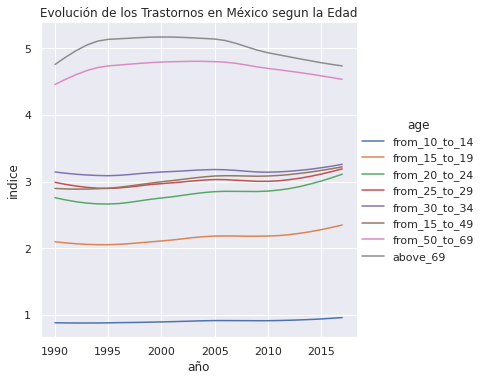

In [42]:
sns.relplot(data=trastornos_mentales_en_mexico_segun_la_edad, x="year", y="rate", hue="age", kind="line").set(title="Evolución de los Trastornos en México segun la Edad", xlabel="año", ylabel="indice");

Hasta ahora, hemos encontrado que el impacto de la __depresion__ depende del __sexo__ y ahora también de la __edad__. Es decir, las mujeres adultas son quienes mas padecen de los __trastornos mentales__ relacionados con la __depresion__.

Lamentablemente la __depresion__ cobra miles de vidas al año y no es un tema facil de hablar, seguiran incrementando los casos de __suicidio__ por __depresion__, a continuacion pronosticaremos el numero de casos de depresion para los proximos 5 años.

Primero, comenzaremos visualizando la dependencia existente entre las columnas de nuestro conjunto de datos.

Este proceso se realiza mediante las funciones <code>corr</code> de la libreria <code>Pandas</code> y <code>heatmap</code> de la libreria <code>Seaborn</code>.

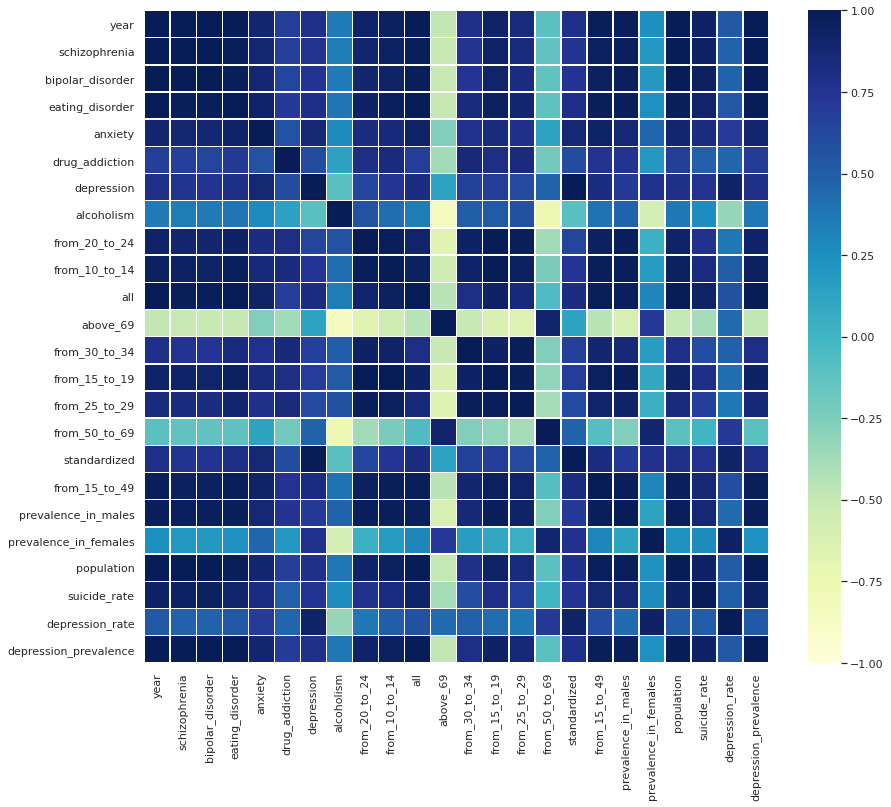

In [43]:
plt.figure(figsize=(14, 12))
sns.heatmap(data=datos_de_mexico.corr(), vmin=-1, vmax=1, linewidths=0.5, cmap="YlGnBu");

Observamos que existen dependencias positivas muy fuertes entre variables, pero unicamente nos interesan las columnas __año__ y __prevalencia de la depresion__.

Es necesario visualizar claramente la distribución de los datos para indagar sobre el posible crecimiento de la __depresion__ a futuro.

Este proceso se realiza mediante la función <code>pairplot</code> de la libreria <code>Seaborn</code>.

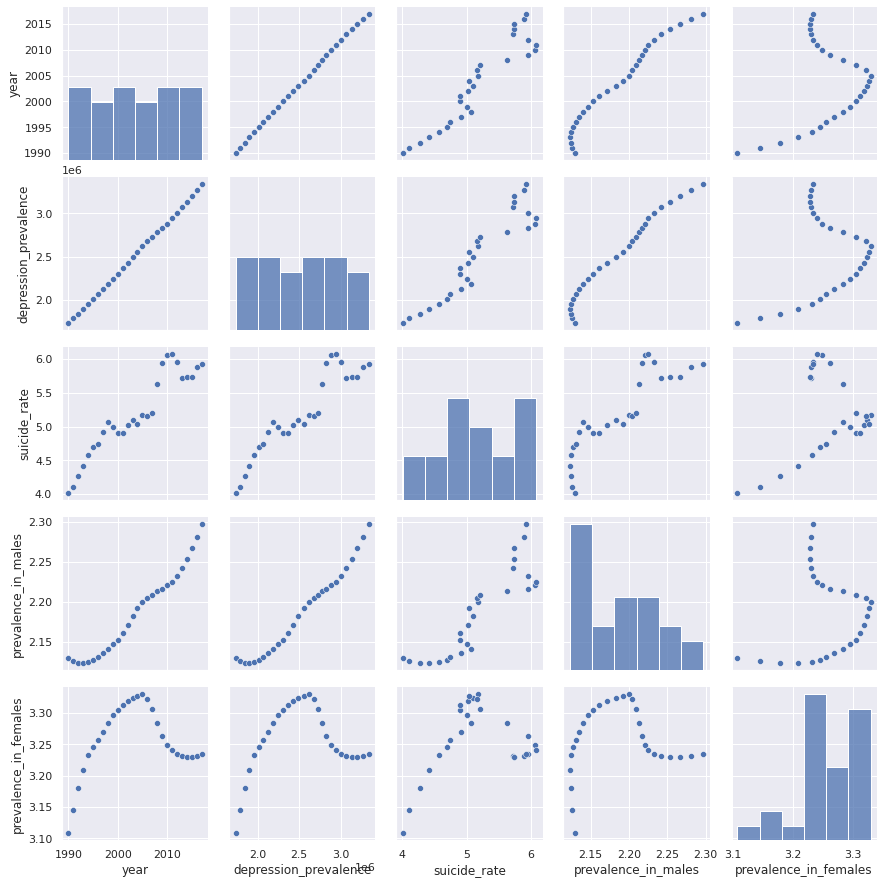

In [44]:
sns.pairplot(datos_de_mexico[["year", "depression_prevalence", "suicide_rate", "prevalence_in_males", "prevalence_in_females"]]);

Como podemos observar la relación entre __año__ y __prevalencia de la depresion__ es completamente lineal, asi que procedemos a realizar la prediccion directamente.

Este proceso se realiza mediante la funcion <code>regresion_lineal</code>.

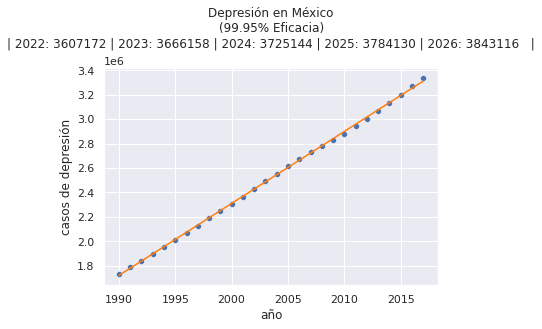

In [45]:
regresion_lineal(datos=datos_de_mexico, independiente="year", dependiente="depression_prevalence", titulo="Depresión en México", etiqueta_x="año", etiqueta_y="casos de depresión")

Como podemos observar, tiene <code>99.95% de eficacia</code>, por lo que no es necesario entrenarlo.

El modelo estimo que dentro de __5 años__, apareceran mas de __200,000 casos de depresion__.

Es por este motivo que el diseño de una herramienta de diagnostico inmediato resulta relevante para la situación futura en __México__.

Un incremento del __indice de depresion__ implica un incremento en el __indice de suicidio__. Ahora conoceremos la situacion a __nivel mundial__ en __2017__.

Este proceso se realiza mediante las funciones <code>groupby</code>, <code>last</code> y <code>reset_index</code> de la libreria <code>Pandas</code> y, <code>treemap</code> de la libreria <code>Plotly</code>.

In [46]:
tasa_de_suicidios = datos_globales.groupby(["region", "sub_region", "country", "year"]).last().reset_index()
px.treemap(tasa_de_suicidios, path=["region", "sub_region", "country", "year"], values="depression_rate", color="suicide_rate", color_continuous_scale="Reds")

Como podemos observar, hay muy poca __tasa de suicidios__ en la mayoria de los paises, pero esto no implica que haya una gran cantidad de personas que acaban con su vida.

Dado que identificar los paises con una alta __tasa de depresion__ es un poco complicado, procedemos graficarlo a nivel mundial en 2017.

Primero, seleccionamos unicamente la informacion correspondiente al año 2017.

In [47]:
datos_globales_2017 = datos_globales[datos_globales["year"] == 2017]

Despues mostramos la información en un __mapa geografico__ de todo el mundo.

Este proceso se realiza mediante la funcion <code>Choropleth</code> de la libreria <code>Plotly</code>.

In [48]:
go.Figure(
    data=go.Choropleth(
        locations=datos_globales_2017["code"],
        z=datos_globales_2017["depression_rate"],
        colorscale="Blues",
        text=datos_globales_2017["country"],
        autocolorscale=False,
    )
).update_layout(
    title_text="Tasa de Depresión",
    title_font_size=24,
    height=500, margin={"r": 0, "t": 50, "l": 0, "b": 0},
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type="equirectangular",
    )
).show()

La información que podemos observar es del año 2017, a pesar de haber trascurrido 4 años, es dificil que la situación haya cambiado. Asi que __Groelandia__ se mantiene aun como el pais con la mayor __tasa de depresion__ en el mundo.

Ahora procedemos a visualizar la __tasa de suicidio__ a nivel mundial en el año 2017.

Este proceso se realiza mediante la funcion <code>Choropleth</code> de la libreria <code>Plotly</code>.

In [49]:
go.Figure(
    data=go.Choropleth(
            locations=datos_globales_2017["code"],
            z=datos_globales_2017["suicide_rate"],
            colorscale="Reds",
            text=datos_globales_2017["country"],
            autocolorscale=False,
        )
    ).update_layout(
        title_text="Tasa de Suicidio",
        title_font_size=24,
        height=500, margin={"r": 0, "t": 50, "l": 0, "b": 0},
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection_type="equirectangular",
        )
    ).show()

Como podemos observar, tambien __Groelandia__ se encuentra como el pais con mayor __tasa de suicidio__ en el mundo.

## Busqueda de sentimientos en estados de WhatsApp

Comenzamos cargando el conjunto de datos que consiste en una recopilacion de __estados de WhatsApp__ que se encuentra almacenado en el repositorio de GitHub.

Este proceso se realiza mediante la función <code>describe</code> de la librería <code>Pandas</code>.

In [50]:
datos_de_whatsapp = pd.read_csv("https://raw.githubusercontent.com/MauricioCarmona/DepresionMexico/main/data/whatsapp_emotions.csv")

Una vez cargados los datos, necesitamos conocer su longitud.

Este proceso se realiza mediante la funcion <code>describe</code> de la librería <code>Pandas</code>.

In [51]:
datos_de_whatsapp.describe()

,content,sentiment
count,1554,1554
unique,1554,3
top,If you don't like me remember it's mind over m...,happy
freq,1,704


Observamos que consta de __1554 entradas__, lo que es un poco pequeño para este analisis pero tambien funciona. Dado que desconocemos si los datos han sido procesados previamente, comenzaremos con la eliminacion de caracteres indeseados.

Este proceso se realiza mediante los metodos <code>lower</code>, <code>replace</code>, <code>strip</code> y <code>contains</code> del objeto <code>string</code> y la funcion <code>head</code> de la libreria <code>Pandas</code>.

In [52]:
datos_de_whatsapp["content"] = datos_de_whatsapp["content"].str.lower().str.replace("[^\w\s]", "", regex=True).str.strip()
datos_de_whatsapp = datos_de_whatsapp[datos_de_whatsapp["content"].str.contains("^[a-z\s]*$", case=False)]
datos_de_whatsapp.head()

,content,sentiment
0,wants to know how the hell i can remember word...,happy
1,love is a long sweet dream marriage is an ala...,happy
2,the world could be amazing when you are slight...,happy
3,my secret talent is getting tired without doin...,happy
4,khatarnaak whatsapp status ever cant talk wife...,happy


Despues creamos un objeto de tipo <code>Text</code> usando <code>datos_de_whatsapp</code>.

Este proceso se realiza mediante las funciones <code>apply</code> y <code>sum</code> de la librería <code>Pandas</code> y, <code>word_tokenize</code> y <code>Text</code> de la librería <code>NLTK</code>.

In [53]:
palabras = datos_de_whatsapp["content"].apply(nltk.word_tokenize).sum()
texto = nltk.Text(palabras)

Ahora exploraremos los conceptos de las palabras <code>happy</code>, <code>sad</code> y <code>angry</code> usando el objeto de tipo <code>Text</code>.

Este proceso se realiza mediante la función <code>similar</code> de la libreria <code>NLTK</code>.

In [54]:
texto.similar("happy")

angry sad good perfect love long yourself much together when are me
about that even careful have feel there and


In [55]:
texto.similar("sad")

angry happy hard next available time yourself like going lucky not up
beautiful tough nice better perfect here loyal hardest


In [56]:
texto.similar("angry")

sad happy but when careful like to know hell what love world way time
if yourself me person today have


Observamos que hay palabras que aparecen a pesar de tener un concepto totalmente diferente, una de las causas puede ser la falta de informacion en nuestro conjunto de datos.

Calculamos la cantidad de palabras unicas, ya que aun no encontramos informacion relevante.

Este proceso se realiza mediante la funcion <code>FreqDist</code> de la libreria <code>NLTK</code>.

In [57]:
frecuencia_de_palabras = nltk.FreqDist(palabras)
print(frecuencia_de_palabras)

<FreqDist with 2425 samples and 20993 outcomes>


Como podemos observar, existen __2425 palabras unicas__. Una aproximacion a conocer las palabras relevantes es visualizar la frecuencia absoluta de cada palabra dentro del conjunto de datos.

Este proceso se realiza mediante la funciones <code>most_common</code> de la librería <code>NLTK</code> y <code>barplot</code> de la libreria <code>Seaborn</code>.

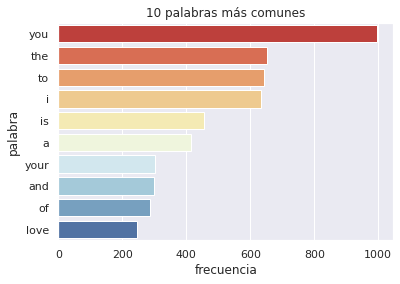

In [58]:
palabras_mas_comunes = pd.DataFrame(frecuencia_de_palabras.most_common(10), columns=["palabra", "frecuencia"])
sns.barplot(data=palabras_mas_comunes, x="frecuencia", y="palabra", orient='h', palette="RdYlBu").set(title="10 palabras más comunes");

Observamos que <code>you</code> es la palabra mas repetida dentro del conjunto de datos a pesar de no ser representativa, asi que es necesario descartar las palabras irrelevantes con alta frecuencia absoluta.

Este proceso se realiza mediante las funciones <code>words</code>, <code>FreqDist</code> y <code>most_common</code> de la libreria <code>NLTK</code> y, <code>barplot</code> de la libreria <code>Seaborn</code>.

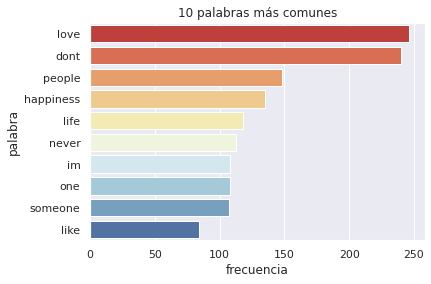

In [59]:
palabras_irrelevantes = stopwords.words("english")
palabras_filtradas = [palabra for palabra in palabras if palabra not in palabras_irrelevantes]
frecuencia_de_palabras_relevantes = nltk.FreqDist(palabras_filtradas)
palabras_relevantes_mas_comunes = pd.DataFrame(frecuencia_de_palabras_relevantes.most_common(10), columns=["palabra", "frecuencia"])
sns.barplot(data=palabras_relevantes_mas_comunes, x="frecuencia", y="palabra", orient='h', palette="RdYlBu").set(title="10 palabras más comunes");

Dado que una palabra por si sola no es representativa, podemos agrupar dos palabras para conocer la frecuencia absoluta con la que aparecen.

Este proceso se realiza mediante las funciones <code>Text</code>, <code>FreqDist</code>, <code>bigrams</code> y <code>most_common</code> de la libreria <code>NLTK</code> y, <code>barplot</code> de la libreria <code>Seaborn</code>.

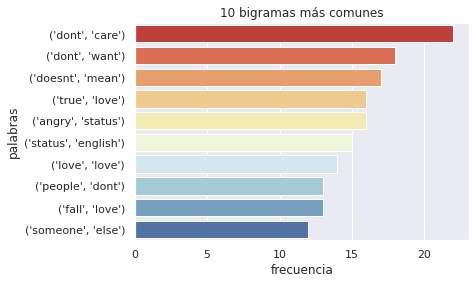

In [60]:
texto_palabras_relevantes = nltk.Text(palabras_filtradas)
frecuencia_de_pares_de_palabras = nltk.FreqDist(list(nltk.bigrams(texto_palabras_relevantes)))
bigramas_mas_comunes = pd.DataFrame(frecuencia_de_pares_de_palabras.most_common(10), columns=["palabras", "frecuencia"])
sns.barplot(data=bigramas_mas_comunes, x="frecuencia", y="palabras", orient='h', palette="RdYlBu").set(title="10 bigramas más comunes");

Tambien podemos conocer la distribucion de la longitud de las palabras.

Este proceso se realiza mediante la funcion <code>histplot</code> de la libreria <code>Seaborn</code>.

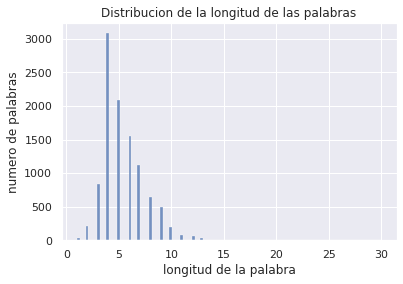

In [61]:
longitud_de_palabras = pd.DataFrame([len(palabra) for palabra in palabras_filtradas], columns=["longitud"])
sns.histplot(data=longitud_de_palabras, x="longitud").set(title="Distribucion de la longitud de las palabras", xlabel="longitud de la palabra", ylabel="numero de palabras");

Si deseamos visualizar claramente las palabras mas frecuentes dentro de nuestro conjunto de datos, podemos emplear una nube de palabras.

Este proceso se realiza mediante un objeto de tipo <code>WordCloud</code>.

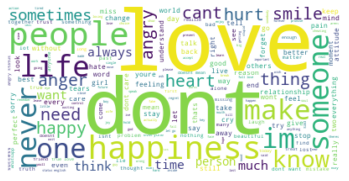

In [62]:
nube_de_palabras = WordCloud(max_font_size=100, background_color="white").generate(' '.join(palabras_filtradas))

plt.imshow(nube_de_palabras, interpolation="bilinear")
plt.axis("off")
plt.show()

Como podemos observar, nuestro conjunto de datos esta conformado de muchas palabras con diferentes conceptos sin explorar, asi que ahora vamos a identificar si existen sentimientos positivos, neutrales o negativos dentro de nuestro conjunto de datos.

Este proceso se realiza mediante un objeto de tipo <code>SentimentIntensityAnalyzer</code> de la librería <code>NLTK</code>, las funciones <code>append</code> de la libreria <code>Pandas</code>,<code>mean</code> de la libreria <code>NumPy</code> y <code>histplot</code> de la libreria <code>Seaborn</code>.

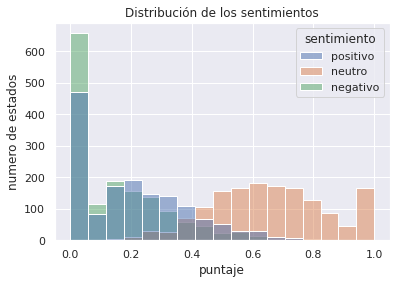

In [63]:
sia = SentimentIntensityAnalyzer()
positivo, neutro, negativo = [], [], []

for estado in datos_de_whatsapp["content"]:
  puntajes = sia.polarity_scores(estado)
  positivo.append(puntajes["pos"])
  neutro.append(puntajes["neu"])
  negativo.append(puntajes["neg"])

positivo = pd.DataFrame(data=positivo, columns=["puntaje"])
positivo["sentimiento"] = "positivo"

neutro = pd.DataFrame(data=neutro, columns=["puntaje"])
neutro["sentimiento"] = "neutro"

negativo = pd.DataFrame(data=negativo, columns=["puntaje"])
negativo["sentimiento"] = "negativo"

sentimientos = positivo.append(neutro.append(negativo))

sns.histplot(data=sentimientos, x="puntaje", hue="sentimiento").set(title="Distribución de los sentimientos", ylabel="numero de estados");

## Detección del Alzheimer

Comenzamos cargando el conjunto de datos sobre el __alzheimer__ que se encuentra almacenado en el repositorio de GitHub.

Este proceso se realiza mediante la funcion <code>read_csv</code> de la librería <code>Pandas</code>.

In [64]:
datos_de_alzheimer = pd.read_csv("https://raw.githubusercontent.com/Al-0/Analisis_Alzheimer/main/shinyapp/Alzheimer/sectional_clean.csv")

Comenzaremos explorando un poco el conjunto de datos.

Este proceso se realiza mediante la función <code>head</code> de la libreria <code>Pandas</code>.

In [65]:
datos_de_alzheimer.head()

,ID,M.F,Age,Educ,SES,MMSE,CDR
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5
3,OAS1_0004_MR1,M,28,NaN,NaN,NaN,NaN
4,OAS1_0005_MR1,M,18,NaN,NaN,NaN,NaN


Como podemos observar, contamos con datos de cada paciente que fue sometido a examenes medicos para la deteccion de __Alzheimer__.

Comenzaremos convirtiendo las variables categoricas __Demente__ y __Sexo__ a variables binarias.

Este proceso se realiza mediante el uso de las funciones <code>apply</code> y <code>dropna</code> de la libreria <code>Pandas</code> y funciones <code>lambda</code>.

In [66]:
datos_de_alzheimer["Demented"] = datos_de_alzheimer["CDR"].apply(lambda x: 1 if x > 0.5 else 0)
datos_de_alzheimer["M.F"] = datos_de_alzheimer["M.F"].apply(lambda x: 1 if x == 'M' else 0)
datos_de_alzheimer = datos_de_alzheimer.dropna()

Ahora creamos nuestras variables <code>X</code> y <code>y</code> que usaremos en el modelo de __regresion logistica__.

Este proceso se realiza mediante la funcion <code>drop</code> de la libreria <code>Pandas</code>.

In [67]:
X = datos_de_alzheimer.drop(columns=["ID", "Demented"])
y = datos_de_alzheimer["Demented"]

Despues creamos y entrenamos nuestro modelo de __regresion logistica__ usando las variables <code>X</code> y <code>y</code>.

Este proceso se realiza mediante las funciones <code>LogisticRegression</code> y <code>fit</code> de la libreria <code>sklearn</code>.

In [68]:
regresion_logistica = LogisticRegression(solver="liblinear", random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
regresion_logistica.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Despues, procedemos a calcular el puntaje de eficacia de nuestro modelo de __regresion logistica__.

Este proceso se realiza mediante la funcion <code>score</code> de la libreria <code>sklearn</code>.

In [69]:
regresion_logistica.score(X_test, y_test)

0.9692307692307692

Ahora, procedemos a calcular la __matriz de confusion__ para conocer la eficacia del modelo de __regresion logistica__ mas a detalle.

Este proceso se realiza mediante las funciones <code>predict</code> y <code>confusion_matrix</code> de la libreria <code>sklearn</code>.

In [70]:
y_pred = regresion_logistica.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[59,  0],
       [ 2,  4]])

Como podemos observar, el modelo es capaz de __clasificar__ correctamente casi todas las entradas que le brindemos.

Ahora, calcularemos a mas detalle las especificaciones del modelo de __regresion logistica__.

Este proceso se realiza mediante las funciones <code>precision_score</code>, <code>accuracy_score</code> y <code>recall_score</code> de la libreria <code>sklearn</code>.

In [71]:
tn, fp, fn, tp = cnf_matrix.ravel()

print("Precision:",metrics.precision_score(y_test, y_pred))
print("Exactitud:",metrics.accuracy_score(y_test, y_pred))
print("Sensibilidad:",metrics.recall_score(y_test, y_pred))
print("Especificidad:", tn / (tn + fp))

Precision: 1.0
Exactitud: 0.9692307692307692
Sensibilidad: 0.6666666666666666
Especificidad: 1.0


Y por ultimo, graficaremos la __curva ROC / AUC__ para conocer el rendimiento de nuestro modelo de __regresion logistica__.

Este proceso se realiza mediante las funciones <code>predict_proba</code>, <code>roc_curve</code> y <code>auc</code> de la libreria <code>sklearn</code>.

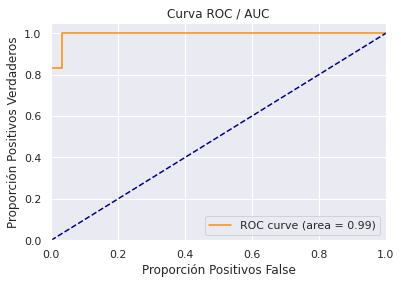

In [72]:
y_pred_proba = regresion_logistica.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange",
         label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Proporción Positivos False")
plt.ylabel("Proporción Positivos Verdaderos")
plt.title("Curva ROC / AUC")
plt.legend(loc="lower right")
plt.show()